In [1]:
import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from dataclasses import dataclass
from pathlib import Path
from tqdm    import tqdm
from typing  import Iterable
import random

import yaml

In [35]:
STAT_DIRECTORY = Path('/home/aroefer/icra_bopt_gmm_exp_door/')
STAT_PATTERN   = 'is_door_*'
DF_BASELINES   = pd.read_csv('/home/aroefer/rl_ws/src/bopt_gmm/data/baselines_door.csv')
OUT_PREFIX     = 'door'
METHOD_NAME    = 'bopt'

In [36]:
@dataclass
class AccuracyStat:
    dir_prefix  : str
    data_points : dict
    components  : int   = 3
    prior       : float = 0.0
    mean        : float = 0.0
    covar       : float = 0.0
    noise       : float = None
    means       : list  = None
    cvars       : list  = None
    cvar_type   : str   = None
    baseline    : float = 0.0
    last_optimization : set = None

def collect_ic_data(files : Iterable[Path], base_lines : dict, base_value=0.0):
    data_points = {}

    perf_base = base_value
    noise = None
    components = None
    opt_episode_step = {}

    # Figure out the number of samples
    samples = set(int(f.parent.name.split('_')[-2]) for f in files)
    sample_idx = dict(zip(samples, range(len(samples))))
    directory_prefix = '_'.join(files[0].parent.name.split('_')[:-2])

    final_perf = {}

    # Collect base array
    for f in files:
        sample = int(f.parent.name.split('_')[-2])
        s_idx  = sample_idx[sample]
        if noise is None:
            components = int([p[-1] for p in f.parent.name.split('_') if len(p) == 2 and p[0] == 'p'][0])

            try:
                df_ic = pd.read_csv(f.parent / f'bopt_initial_conditions.csv')
                opt_substeps = {bs: df_ic[df_ic.bopt_step == bs].substep.max() for bs in df_ic.bopt_step.unique()}
                epsiode_counter = 0
                for bs, ss in sorted(opt_substeps.items()):
                    opt_episode_step[bs] = epsiode_counter
                    epsiode_counter += ss
            except pd.errors.EmptyDataError:
                if METHOD_NAME != 'sacgmm':
                    raise Exception(f'CSV "{f.parent / f"{METHOD_NAME}_initial_conditions.csv"}" seems to be empty.')

            with open(f.parent / 'config.yaml') as cf:
                config = yaml.safe_load(cf)
            model = config['bopt_agent']['gmm']['model']

            noise = config['env']['noise']['position']['variance']
            if model in base_lines:
                perf_base = base_lines[model][noise]

        try:
            df  = pd.read_csv(f)
        except pd.errors.EmptyDataError:
            continue
        idx = int(f.name.split('_')[-2])
        if idx not in data_points:
            data_points[idx] = [None] * len(samples)
        
        if sample not in final_perf:
            final_perf[sample] = 0 

        final_perf[sample] = max(final_perf[sample], idx)

        data_points[idx][s_idx] = df.success.mean()
    
    sorted_keys = sorted(data_points.keys())
    for x in range(len(sorted_keys)):
        if x == 0:
            data_points[sorted_keys[x]] = [v if v is not None else perf_base for v in data_points[sorted_keys[x]]]
        else:
            data_points[sorted_keys[x]] = [v if v is not None else data_points[sorted_keys[x-1]][y] for y, v in enumerate(data_points[sorted_keys[x]])]

    if METHOD_NAME == 'sacgmm':
        opt_episode_step = dict(zip(sorted_keys, sorted_keys))

    data_points = {opt_episode_step[k]: v for k, v in data_points.items()}

    final_perf = {opt_episode_step[v] for v in final_perf.values()}

    return AccuracyStat(directory_prefix,
                        data_points,
                        components,
                        config['bopt_agent']['prior_range'],
                        config['bopt_agent']['mean_range'],
                        config['bopt_agent']['sigma_range'],
                        noise,
                        config['bopt_agent']['opt_dims']['means'],
                        config['bopt_agent']['opt_dims']['cvars']['nary'],
                        config['bopt_agent']['opt_dims']['cvars']['type'] if 'type' in config['bopt_agent']['opt_dims']['cvars'] else '',
                        perf_base,
                        final_perf)

In [37]:
patterns = set()

for d in STAT_DIRECTORY.glob(STAT_PATTERN):
    parts = d.name.split('_')
    try:
        int(parts[-2])
        parts[-2] = '*'
        patterns.add('_'.join(parts) + '/eval_*_ic.csv')
    except ValueError:
        pass

print(len(patterns))

44


In [38]:
baselines = {m: dict(DF_BASELINES[DF_BASELINES.model == m][['noise', 'accuracy']].to_numpy()) 
             for m in DF_BASELINES.model.unique()}
print(baselines)

{'models/gmm/sd_3p_f.npy': {0.0: 0.58, 0.01: 0.54, 0.02: 0.44, 0.03: 0.34, 0.05: 0.27}, 'models/gmm/sd_3p_js.npy': {0.0: 0.43, 0.01: 0.39, 0.02: 0.36, 0.03: 0.37, 0.05: 0.34}, 'models/gmm/sd_3p.npy': {0.0: 0.59, 0.01: 0.55, 0.02: 0.46, 0.03: 0.47, 0.05: 0.29}, 'models/gmm/sd_3p_t.npy': {0.0: 0.0, 0.01: 0.0, 0.02: 0.01, 0.03: 0.02, 0.05: 0.06}, 'models/gmm/sd_5p_f.npy': {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0.05: 0.0}, 'models/gmm/sd_5p_js.npy': {0.0: 0.68, 0.01: 0.7, 0.02: 0.57, 0.03: 0.52, 0.05: 0.28}, 'models/gmm/sd_5p.npy': {0.0: 0.81, 0.01: 0.73, 0.02: 0.73, 0.03: 0.53, 0.05: 0.32}, 'models/gmm/sd_5p_t.npy': {0.0: 0.0, 0.01: 0.0, 0.02: 0.04, 0.03: 0.0, 0.05: 0.03}, 'models/gmm/sd_7p_f.npy': {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0.05: 0.0}, 'models/gmm/sd_7p_js.npy': {0.01: 0.6, 0.02: 0.55, 0.03: 0.42, 0.05: 0.24}, 'models/gmm/sd_7p.npy': {0.0: 0.8, 0.01: 0.78, 0.02: 0.57, 0.03: 0.48, 0.05: 0.3}, 'models/gmm/sd_7p_t.npy': {0.01: 0.0, 0.02: 0.0, 0.03: 0.02, 0.05: 0.01}}


In [39]:
all_data   = [] 
data_names = []
data_by_hash = {}

for p in tqdm(patterns, desc='Processing patters'):
    files = list(STAT_DIRECTORY.glob(p))
    if len(files) > 0:
        all_data.append(collect_ic_data(files, baselines))
        data_names.append(Path(p.replace('_*', '')).parent.name)
        dhash = Path(p.replace('_*', '')).parent.name.split('_')[-1]
        data_by_hash[dhash] = all_data[-1]
    else:
        print(f'Pattern "{p}" yielded no files.')
print(all_data)

Processing patters: 100%|██████████| 44/44 [00:10<00:00,  4.36it/s]

[AccuracyStat(dir_prefix='is_sd_p5_n00_hpo_wpv_sR', data_points={21: [0.76, 0.74, 0.82, 0.74, 0.82, 0.82, 0.8, 0.84, 0.68, 0.78, 0.8, 0.78, 0.88, 0.88, 0.82, 0.88], 0: [0.9, 0.72, 0.76, 0.86, 0.82, 0.82, 0.82, 0.84, 0.78, 0.78, 0.84, 0.9, 0.86, 0.84, 0.8, 0.82], 343: [0.98, 0.74, 0.94, 0.98, 0.92, 1.0, 0.8, 0.84, 0.98, 0.78, 0.98, 0.94, 0.94, 0.82, 0.9, 1.0], 28: [0.76, 0.74, 0.82, 0.74, 0.82, 0.82, 0.8, 0.84, 0.68, 0.78, 0.8, 0.92, 0.88, 0.88, 0.82, 0.88], 7: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 231: [0.98, 0.74, 0.94, 0.98, 0.92, 1.0, 0.8, 0.84, 0.98, 0.78, 0.98, 0.92, 0.88, 0.94, 0.9, 1.0], 84: [0.98, 0.74, 0.82, 0.74, 0.82, 0.82, 0.8, 0.84, 0.98, 0.78, 0.8, 0.92, 0.88, 0.88, 0.9, 0.88], 217: [0.98, 0.74, 0.94, 0.98, 0.92, 1.0, 0.8, 0.84, 0.98, 0.78, 0.98, 0.92, 0.88, 0.94, 0.9, 0.88], 98: [0.98, 0.74, 0.82, 0.74, 0.82, 0.82, 0.8, 0.84, 0.98, 0.78, 0.8, 0.92, 0.88, 0.94, 0.9, 0.88], 154: [0.98, 0.74, 0.82, 0.98, 0.92, 0.82, 0.8, 0.84, 0.9

In [40]:
len(all_data[0].data_points[sorted(all_data[0].data_points.keys())[0]])

16

In [41]:
def draw_var_plot(ax, data, color, label):
    x_coords = sorted(data.keys())
    d        = np.vstack([data[k] for k in x_coords])
    means_ps = np.mean(d, axis=1)
    stds_ps  = np.std(d, axis=1)
    ax.plot(x_coords, means_ps, label=label, c=color)
    ax.fill_between(x_coords, means_ps-stds_ps, means_ps+stds_ps, alpha=0.3, facecolor=color)

In [42]:
COLORS = np.array([['#12DB00', '#70F20C', '#B8E80C', '#0CF23E', '#0CE879'],
                   ['#DB6300', '#F2520C', '#E82F0C', '#F2940C', '#E8A40C'],
                   ['#42CEF5', '#31DED5', '#37FAB9', '#318BDE', '#3769FA'],
                   ['#F4D221', '#DEA814', '#FAA717', '#DED114', '#DFFA17'],
                   ['#F51D4F', '#DE10A7', '#DD12FA', '#DE2010', '#FA4612'],
                   ['#7C15F5', '#3209DE', '#0A1CFA', '#A609DE', '#FA0AF5'],
                   ['#1B3EF5', '#0D67DE', '#0FB2FA', '#220DDE', '#670FFA']])

COLORS_RANDOM = COLORS.flatten().copy() 
random.shuffle(COLORS.flatten())

In [43]:
import math

In [44]:
for a in all_data:
    print(a.noise)

0.0
0.01
0.0
0.03
0.01
0.03
0.02
0.02
0.01
0.03
0.0
0.0
0.03
0.02
0.01
0.0
0.03
0.02
0.03
0.01
0.0
0.03
0.03
0.01
0.0
0.01
0.01
0.02
0.0
0.0
0.02
0.01
0.02
0.0
0.03
0.0
0.01
0.02
0.02
0.02
0.03
0.01
0.02
0.03


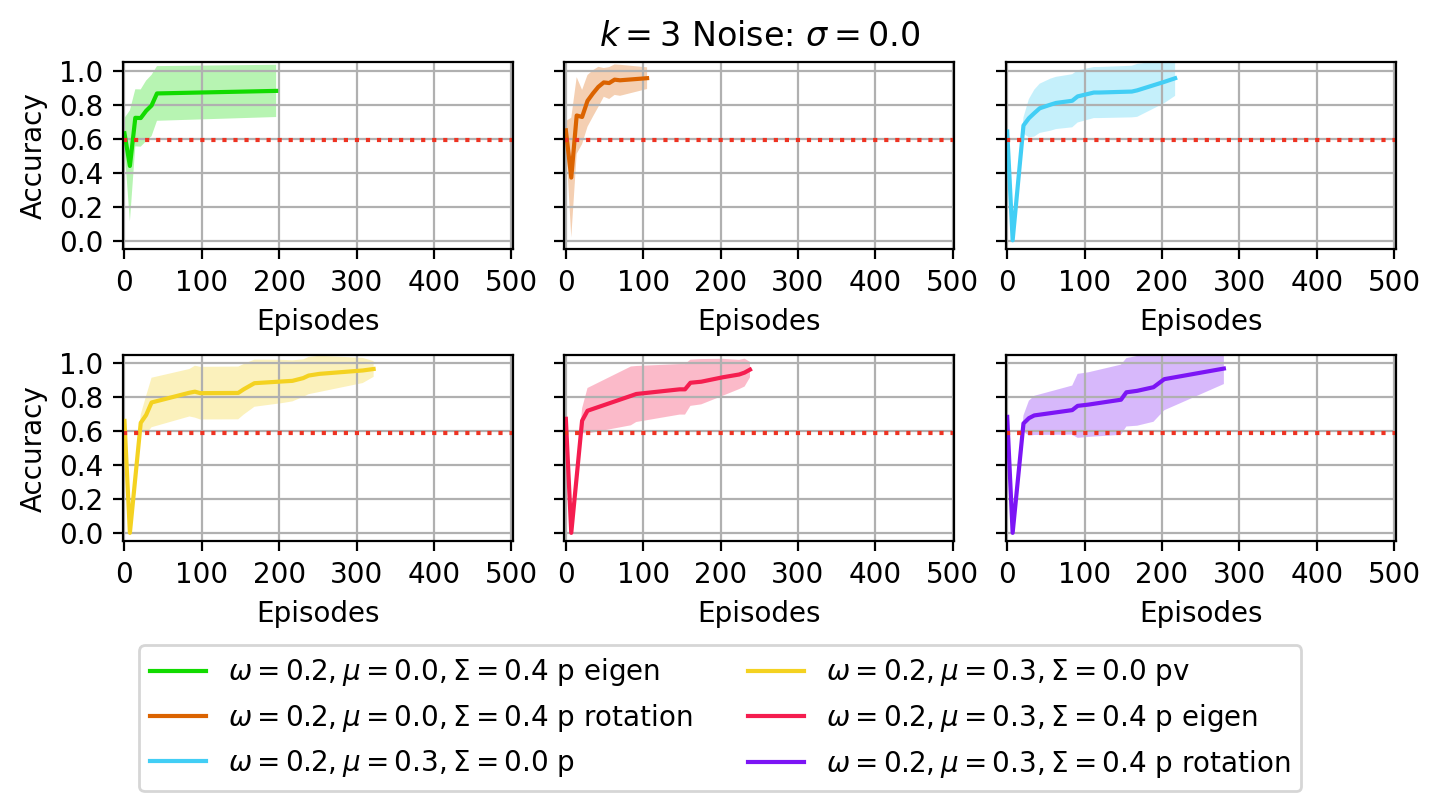

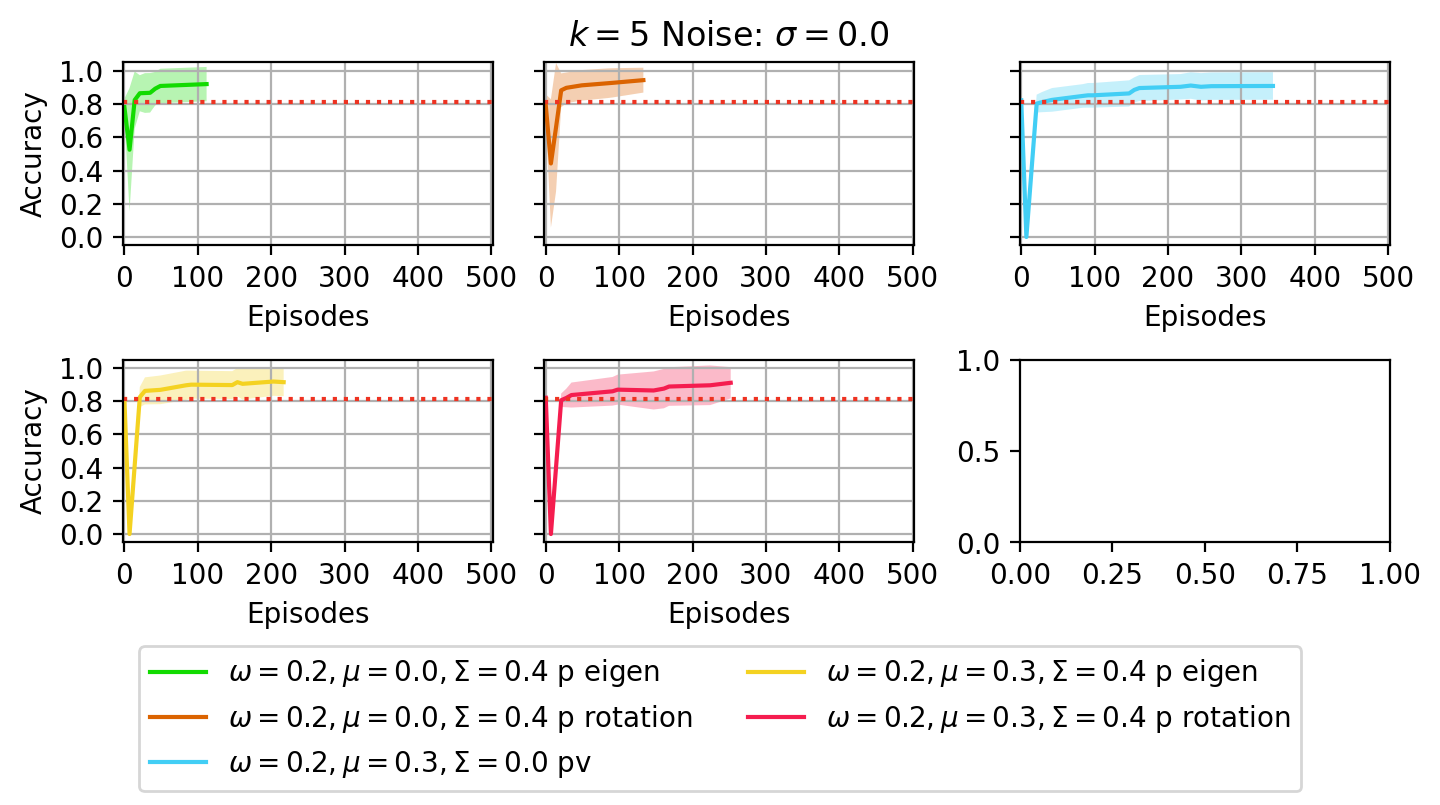

In [45]:
def str_as(a : AccuracyStat):
    return f'$\omega = {a.prior}, \mu = {a.mean}, \Sigma = {a.covar}$ {"".join([m[0] for m in a.means])} {a.cvar_type}'

noise_filter = 0.0

filtered_data = [(str_as(a), a) for a in all_data if a.noise == noise_filter]

components = sorted({a.components for _, a in filtered_data})
data_by_components = {c: [(label, a) for label, a in filtered_data if a.components == c] for c in components}

for c, data in data_by_components.items():
    n_cols = int(math.ceil(len(data) / 3))
    fig, axes = plt.subplots(n_cols, 3, figsize=((6 * 3) / 2.54, (5 * n_cols) / 2.54), layout='constrained', dpi=200)

    legend = {}
    colors = {}

    for x, ((label, ac_stat), ax) in enumerate(zip(sorted(data, key=lambda t: t[0]), axes.flatten())):  # type data: AccuracyStat
        if x % 3 == 0:
            ax.set_yticks(np.linspace(0.0, 1.0, 6))
            ax.set_ylabel('Accuracy')
        else:
            ax.set_yticks(np.linspace(0.0, 1.0, 6), [])


        if label not in colors:
            colors[label] = COLORS.T.flatten()[len(colors)]

        draw_var_plot(ax, ac_stat.data_points, colors[label], label)

        ax.set_xlabel('Episodes')
        ax.set_xticks(np.linspace(0, 500, 6))
        if x == min(len(data) - 1, 1):
            ax.set_title(f'$k = {c}$ Noise: $\sigma = {noise_filter}$')
        ax.grid(True)
        # if x == 0:
        #     ax.legend(bbox_to_anchor=(0., -.92, 2.2, .102),  loc='lower left',
        #                   ncols=3, mode="expand", borderaxespad=0)
        ax.set_ylim((0 - 0.05, 1.0 + 0.05))
        ax.set_xlim((0 - 2, 500 + 2))
        handles, labels = ax.get_legend_handles_labels()
        legend.update(dict(zip(labels, handles)))

        ax.hlines(ac_stat.baseline, *ax.get_xlim(), color='#ee3322', linestyle='dotted')

    fig.legend(legend.values(), legend.keys(), loc='outside lower center', ncols=2)
    fig.savefig(f'plots/{OUT_PREFIX}_p{c}_n{int(noise_filter*100):02d}.png')
# fig.tight_layout()


In [46]:
for dn, ac in zip(data_names, all_data):
    pd.DataFrame(np.vstack([(x, np.mean(d), np.std(d)) for x, d in sorted(ac.data_points.items())]),
                 columns=['x', 'y', 'std']).to_csv(f'data/{METHOD_NAME}_{dn}.csv', index=False)

In [47]:
columns = 'k omega mu sigma mu_dim sigma_type noise accuracy episode_count baseline mean_final std_final'.split(' ')

data = []

for a in all_data:  
    a = a # type: AccuracyStat
    last_data = sorted(a.data_points.keys())[-1]
    data.append([a.components, a.prior, a.mean, a.covar, ' '.join(a.means), a.cvar_type, a.noise,
                 np.mean(a.data_points[last_data]), last_data, a.baseline, np.mean(list(a.last_optimization)),
                 np.std(list(a.last_optimization))])

pd.DataFrame(data, columns=columns).to_csv(f'plots/{OUT_PREFIX}_stats.csv', index=False)

In [48]:
config_data_by_headers    = {}
incumbent_data_by_headers = {}

for d in tqdm(list(STAT_DIRECTORY.glob(STAT_PATTERN)), desc='Reading bopt configs...'):
    dhash = d.name.split('_')[-1]

    ac_stat = data_by_hash[dhash]

    try:
        df_config = pd.read_csv(d / 'bopt_configs.csv')
    except pd.errors.EmptyDataError:
        continue
    # Relabel eigen updates based on type
    if ac_stat.cvar_type == 'rotation':
        columns = [c if c[:2] != 'e_' else 'rot_' + c[2:] for c in df_config.columns]
    else:
        columns = df_config.columns

    header_key = ','.join(columns)
    if header_key not in config_data_by_headers:
        config_data_by_headers[header_key] = []
    
    config_data_by_headers[header_key].append(df_config.to_numpy())

    df_config = pd.read_csv(d / 'bopt_incumbents.csv')
    # Relabel eigen updates based on type
    if ac_stat.cvar_type == 'rotation':
        columns = [c if c[:2] != 'e_' else 'rot_' + c[2:] for c in df_config.columns]
    else:
        columns = df_config.columns

    header_key = ','.join(columns)
    if header_key not in incumbent_data_by_headers:
        incumbent_data_by_headers[header_key] = []
    
    incumbent_data_by_headers[header_key].append(df_config.to_numpy())


Reading bopt configs...: 100%|██████████| 702/702 [00:03<00:00, 213.95it/s]


In [49]:
list(config_data_by_headers.keys())

['accuracy,bopt_step,e_0_position|velocity_0,e_0_position|velocity_1,e_0_position|velocity_2,e_1_position|velocity_0,e_1_position|velocity_1,e_1_position|velocity_2,e_2_position|velocity_0,e_2_position|velocity_1,e_2_position|velocity_2,weight_0,weight_1,weight_2',
 'accuracy,bopt_step,rot_0_position|velocity_0,rot_0_position|velocity_1,rot_0_position|velocity_2,rot_1_position|velocity_0,rot_1_position|velocity_1,rot_1_position|velocity_2,rot_2_position|velocity_0,rot_2_position|velocity_1,rot_2_position|velocity_2,rot_3_position|velocity_0,rot_3_position|velocity_1,rot_3_position|velocity_2,rot_4_position|velocity_0,rot_4_position|velocity_1,rot_4_position|velocity_2,weight_0,weight_1,weight_2,weight_3,weight_4',
 'accuracy,bopt_step,mean_position_0_0,mean_position_0_1,mean_position_0_2,mean_position_1_0,mean_position_1_1,mean_position_1_2,mean_position_2_0,mean_position_2_1,mean_position_2_2,mean_position_3_0,mean_position_3_1,mean_position_3_2,mean_position_4_0,mean_position_4_1,mea

In [50]:
neutral_values = {'e' : 1.0, 'mean': 0.0, 'weight': 0.0, 'rot': 0.0}

def join_tables(header_data_dict : dict, neutral_values: dict) -> pd.DataFrame:
    joint_header = list(set(sum([k.split(',') for k in header_data_dict.keys()], [])))

    full_data = []

    for c, d in header_data_dict.items():
        c = c.split(',')
        d = np.vstack(d)
        
        new_data = np.ones((d.shape[0], len(joint_header)))

        for x, column in enumerate(joint_header):
            try:
                ox = c.index(column)
                new_data[:, x] = d[:, ox]
            except ValueError:
                prefix = column.split('_')[0]
                new_data[:, x] = neutral_values[prefix]
        
        full_data.append(new_data)
    
    return pd.DataFrame(np.vstack(full_data), columns=joint_header)

join_tables(config_data_by_headers, neutral_values).to_csv(f'data/{OUT_PREFIX}_configs.csv', index=False)
join_tables(incumbent_data_by_headers, neutral_values).to_csv(f'data/{OUT_PREFIX}_incumbents.csv', index=False)

In [60]:
final_acc_eigen = []
final_acc_rot   = []
final_acc_mean  = []
final_acc_prior = []


for a in all_data: # type: AccuracyStat
    # if a.noise != 0.01:
    #     continue
    if a.prior != 0.0 and a.mean == 0.0 and a.covar == 0.0:
        final_acc_prior.append(np.mean(a.data_points[max(a.data_points.keys())]))
    elif a.prior != 0.0 and a.mean != 0.0 and a.covar == 0.0:
        final_acc_mean.append(np.mean(a.data_points[max(a.data_points.keys())]))
    elif a.prior != 0.0 and a.mean != 0.0 and a.covar != 0.0 and a.cvar_type == 'eigen':
        final_acc_eigen.append(np.mean(a.data_points[max(a.data_points.keys())]))
    elif a.prior != 0.0 and a.mean != 0.0 and a.covar != 0.0 and a.cvar_type == 'rotation':
        final_acc_rot.append(np.mean(a.data_points[max(a.data_points.keys())]))

# print(f'Eigen: {np.mean(final_acc_eigen)}')
# print(f'Rot: {np.mean(final_acc_rot  )}')
# print(f'Mean: {np.mean(final_acc_mean )}')

perf_reached_after_eigen = []
perf_reached_after_rot   = []
perf_reached_after_mean  = []
perf_reached_after_prior = []
threshold = 0.8

for a in all_data: # type: AccuracyStat
    # if a.noise != 0.02:
    #     continue

    for s, d in sorted(a.data_points.items()):
        if np.mean(d) >= threshold:
            break
    else:
        s = 500

    if a.prior != 0.0 and a.mean == 0.0 and a.covar == 0.0:
        perf_reached_after_prior.append(s)
    elif a.prior != 0.0 and a.mean != 0.0 and a.covar == 0.0:
        perf_reached_after_mean.append(s)
    elif a.prior != 0.0 and a.mean != 0.0 and a.covar != 0.0 and a.cvar_type == 'eigen':
        perf_reached_after_eigen.append(s)
    elif a.prior != 0.0 and a.mean != 0.0 and a.covar != 0.0 and a.cvar_type == 'rotation':
        perf_reached_after_rot.append(s)

print(f'Eigen accuracy >= {threshold} after: {np.mean(perf_reached_after_eigen)}')
print(f'Rot accuracy >= {threshold} after: {np.mean(perf_reached_after_rot  )}')
print(f'Mean accuracy >= {threshold} after: {np.mean(perf_reached_after_mean )}')


Eigen accuracy >= 0.8 after: 284.125
Rot accuracy >= 0.8 after: 297.25
Mean accuracy >= 0.8 after: 291.1666666666667
